# Imports & basics

In [ ]:
# -- path info --
path_to_repo = "/Users/mbaranov/python_wd/credit_scoring_project"
dataset_nm = "05_defaults_cc"

# -- experiments logging --
experiment_dir = "test"
! mkdir "test"
# -- --

n_total = 200
top_k = 20

load = False                      # whether to train models or load from json

In [1]:
# --- base ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import json
import importlib
import optuna
optuna.logging.set_verbosity(1)  # default 20

import sys
seed = 89

# --- sklearn ---
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, StratifiedKFold
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler

# --- modules ---
sys.path.insert(1, path_to_repo)  # directory with modules
from modules.feature_selection import SafeSelectByShuffling
from modules.encoders import WoEEncoder_adj

import modules.optuna_instruments
from modules.optuna_instruments import optimized_function, get_top_k_models, get_top_test_scores

# --- load data ---
X_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_train.parquet")
y_train = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_train.parquet")["target"]
X_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/X_test.parquet")
y_test = pd.read_parquet(f"{path_to_repo}/datasets/{dataset_nm}/samples/y_test.parquet")["target"]
with open(f"{path_to_repo}/datasets/{dataset_nm}/factors.json", "r") as f:
    factors = json.load(f)

sample_info = {
    "X_train" : X_train,
    "y_train" : y_train,
    "X_test" : X_test, 
    "y_test" : y_test,
    "loss" : roc_auc_score
}

# Data transformations

# Baseline pipeline

## Run models

In [3]:
# baseline modules
woe_encoder = WoEEncoder_adj(variables=factors["cat_vals"], ignore_format=True)
setattr(woe_encoder, "pipeline_nm", "cat_feat_WoEEnc")

StandSc_module = SklearnTransformerWrapper(StandardScaler(), variables=factors["num_vals"])
setattr(StandSc_module, "pipeline_nm", "scaling_StSc")

sel_shuffl = SafeSelectByShuffling(estimator=LogisticRegression(max_iter=500, solver="newton-cg"), min_features=1, variables=None, random_state=seed)
setattr(sel_shuffl, "pipeline_nm", "feat_sel_SelShuffl")

logreg = LogisticRegression(max_iter=1000, solver="newton-cg")
setattr(logreg, "pipeline_nm", "classifier_LogReg")

# no choice for baseline pipeline
stages_options_baseline = {
    "cat_feat" : [woe_encoder],
    # "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : [],
    "classifier" : [logreg]
}

# hparameters only for classifier
hparams_options_baseline = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [5]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "r") as f:
        baseline_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_baseline = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed) 
        )

    study_baseline.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_baseline, hparams_options=hparams_options_baseline, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    baseline_results = [
        {"value" : study_baseline.trials[i].value, "params" : study_baseline.trials[i].params} for i in range(len(study_baseline.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_baseline.json", "w") as f:
        json.dump(baseline_results, f)

[I 2022-04-28 18:33:38,698] A new study created in memory with name: no-name-b6b8413f-8725-47cb-91ba-2f2e2323cea4
[I 2022-04-28 18:33:40,245] Trial 0 finished with value: 0.7405626085303598 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 50}. Best is trial 0 with value: 0.7405626085303598.
[I 2022-04-28 18:33:41,664] Trial 1 finished with value: 0.7405624473276915 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 0 with value: 0.7405626085303598.
[I 2022-04-28 18:33:43,210] Trial 2 finished with value: 0.7405624473276915 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 26}. Best is trial 0 with value: 0.7405626085303598.
[I 2022-04-28 18:33:44,634] Trial 3 finished with value: 0.7405621450040573 and parameters: {'cat_feat': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 0 with value: 0.7405626085303598.
[I 2022-04-28 18:3

## Results

''

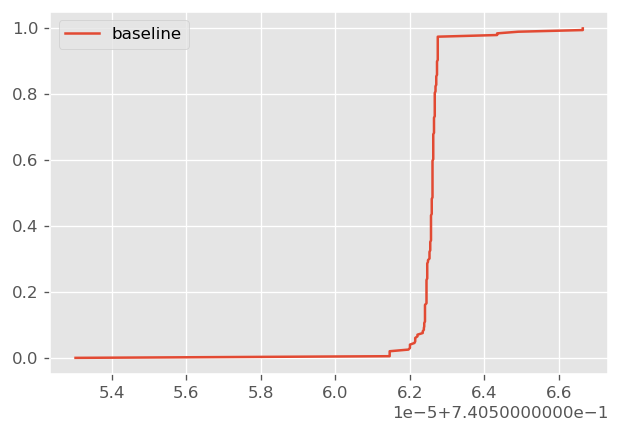

In [6]:
plt.figure(dpi=120)

auc_values_baseline = np.array([elem["value"] for elem in baseline_results])
t = np.linspace(0, 1, n_total)

plt.plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
plt.legend()

# plt.plot(auc_values)
;

In [8]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_baseline = get_top_test_scores(baseline_results, top_k=top_k, stages_options=stages_options_baseline, **sample_info)
print(scores_baseline)

  0%|          | 0/20 [00:00<?, ?it/s]

[0.7259346  0.7259346  0.72593525 0.72593089 0.72593089 0.72593637
 0.72593637 0.72593637 0.72593637 0.72593637 0.72593637 0.72593637
 0.72593637 0.72593637 0.72593637 0.72593637 0.72593637 0.72593637
 0.72593637 0.72593637]


# Categorical encoding

## Run models

In [9]:
from feature_engine.encoding import DecisionTreeEncoder, MeanEncoder, OneHotEncoder

DT_encoder = DecisionTreeEncoder(variables=factors["cat_vals"], ignore_format=True, regression=False, random_state=seed)
setattr(DT_encoder, "pipeline_nm", "cat_feat_DT")

OHE_encoder = OneHotEncoder(
    variables=factors["cat_vals"], drop_last_binary=True, ignore_format=True
)
setattr(OHE_encoder, "pipeline_nm", "cat_feat_OHE")

mean_encoder = MeanEncoder(variables=factors["cat_vals"], ignore_format=True)
setattr(mean_encoder, "pipeline_nm", "cat_feat_MeanEnc")

# -- --

stages_options_encoding = {
    "cat_feat" : [woe_encoder, DT_encoder, OHE_encoder, mean_encoder],  # changes only here; CF gives warning
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg]
}

hparams_options_encoding = {
    "cat_feat_CF" : lambda trial: {
        "cat_feat_CF__encoding_method" : trial.suggest_categorical("cat_feat_CF__encoding_method", ["count", "frequency"])
    },
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [10]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_encoding.json", "r") as f:
        encoding_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_encoding = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    strategy="kfold"
    study_encoding.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_encoding, hparams_options=hparams_options_encoding, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )


    # -- save results to json --
    encoding_results = [
        {"value" : study_encoding.trials[i].value, "params" : study_encoding.trials[i].params} for i in range(len(study_encoding.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_encoding.json", "w") as f:
        json.dump(encoding_results, f)

[I 2022-04-28 18:39:10,040] A new study created in memory with name: no-name-8eb340e0-fb84-4f3d-b956-68ae6b9bd019
[I 2022-04-28 18:39:11,077] Trial 0 finished with value: 0.7396528287756805 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 57}. Best is trial 0 with value: 0.7396528287756805.
[I 2022-04-28 18:39:12,794] Trial 1 finished with value: 0.7457199324983668 and parameters: {'cat_feat': 2, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 42}. Best is trial 1 with value: 0.7457199324983668.
[I 2022-04-28 18:39:13,924] Trial 2 finished with value: 0.7396522650039508 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 11}. Best is trial 1 with value: 0.7457199324983668.
[I 2022-04-28 18:39:15,145] Trial 3 finished with value: 0.7419887813718382 and parameters: {'cat_feat': 3, 'scaling': 0, 'feat_sel': 0, 'imb_data':

## Results

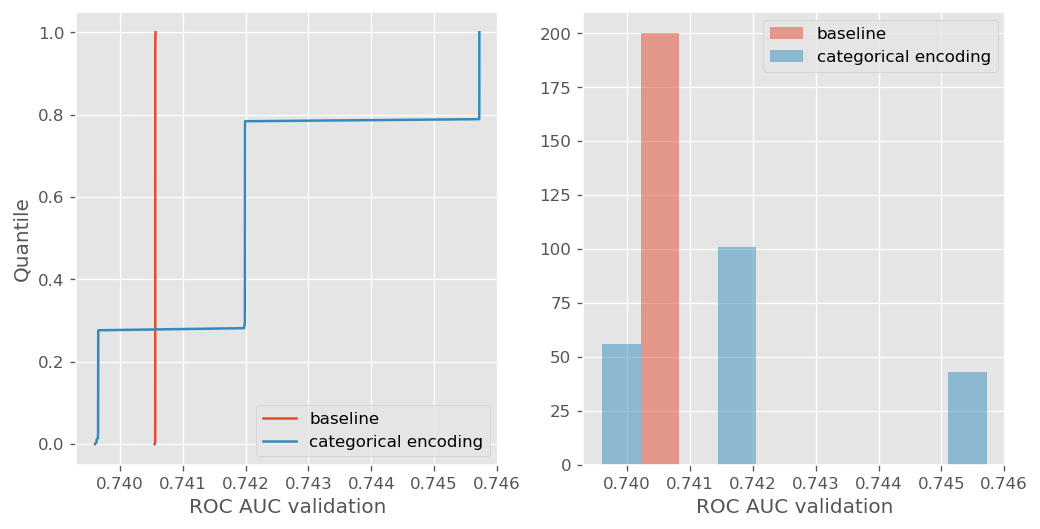

In [11]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_encoding = np.array([elem["value"] for elem in encoding_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_encoding])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_encoding), t, c="C1", label="categorical encoding")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_encoding, bins=bin_edges, alpha=0.5, label="categorical encoding")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [12]:
scores_encoding = get_top_test_scores(encoding_results, top_k=top_k, stages_options=stages_options_encoding, **sample_info)
print(np.mean(
    scores_encoding.reshape(-1, 1) > scores_baseline
))

print(f"mean diff {np.mean(scores_encoding) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

1.0
mean diff 0.005283


# Feature selection

## Run models

In [13]:
from modules.feature_selection import SafeSelectBySingleFeaturePerformance
from feature_engine.selection import SmartCorrelatedSelection

# -- additional feature selection options --
SinglePerf_module = SafeSelectBySingleFeaturePerformance(  # rather slow
    estimator=LogisticRegression(max_iter=500),
    scoring="roc_auc",
    threshold=None,               # will be automatically set to the mean performance value of all features
)
setattr(SinglePerf_module, "pipeline_nm", "feat_sel_SinglePerf")

SmartSel_module = SmartCorrelatedSelection(
    variables=None,                  # If None, the transformer will evaluate all numerical variables in the dataset.  -- нужен класс.
    method="pearson",                # can be replaced by a custom function
    threshold=0.3,                   # correlation threshold
    selection_method="variance",     # select feature with greatest variance from a correlated group
    estimator=None,                  # for selection_method="model_performance"        
    cv=5
)
setattr(SmartSel_module, "pipeline_nm", "feat_sel_SmartSel")
# --- ---

stages_options_feat_sel = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl, SinglePerf_module, SmartSel_module],  # changes only here
    "imb_data" : [],
    "classifier" : [logreg]
}

hparams_options_feat_sel = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "feat_sel_SinglePerf" : lambda trial: {
        "feat_sel_SinglePerf__threshold" : trial.suggest_float("feat_sel_SinglePerf__threshold", low=0.5, high=0.6)
    }
}

In [14]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "r") as f:
        feat_sel_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_feat_sel = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_feat_sel.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_feat_sel, hparams_options=hparams_options_feat_sel, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )


    # -- save results to json --
    feat_sel_results = [
        {"value" : study_feat_sel.trials[i].value, "params" : study_feat_sel.trials[i].params} for i in range(len(study_feat_sel.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_feat_sel.json", "w") as f:
        json.dump(feat_sel_results, f)

[I 2022-04-28 18:44:02,562] A new study created in memory with name: no-name-f5ace6f3-bfd3-43a0-a3cd-d3607a902054
[I 2022-04-28 18:44:03,591] Trial 0 finished with value: 0.7396518720055144 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 10}. Best is trial 0 with value: 0.7396518720055144.
[I 2022-04-28 18:44:04,598] Trial 1 finished with value: 0.7396527682913836 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'classifier': 0, 'classifier_LogReg__C': 49}. Best is trial 1 with value: 0.7396527682913836.
/Users/mbaranov/miniforge3/envs/scoring_project/lib/python3.8/site-packages/feature_engine/selection/smart_correlation_selection.py:291: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  f = X[feature_group].std().sort_values(ascending=False).index[0]
/Users/mbaranov/miniforge3/envs/scoring_project/lib/python3.8/site-packages/feature_engine/selection/smart_

## Results

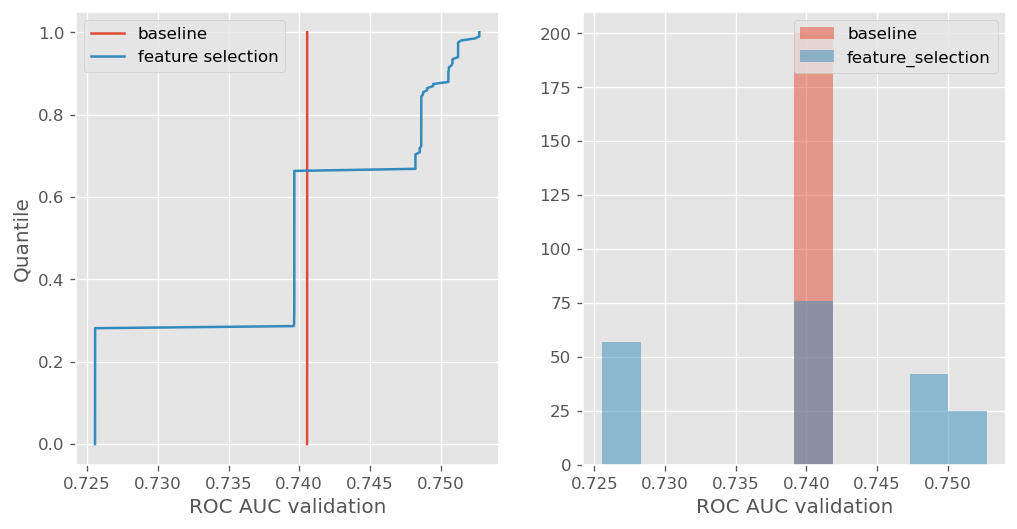

In [15]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_feat_sel = np.array([elem["value"] for elem in feat_sel_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_feat_sel])


ax[0].plot(np.sort(auc_values_baseline), np.linspace(0, 1, len(auc_values_baseline)), c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_feat_sel), np.linspace(0, 1, len(auc_values_feat_sel)), c="C1", label="feature selection")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_feat_sel, bins=bin_edges, alpha=0.5, label="feature_selection")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [16]:
scores_feat_sel = get_top_test_scores(feat_sel_results, top_k=top_k, stages_options=stages_options_feat_sel, **sample_info)
print(scores_feat_sel)
print(np.mean(
    scores_feat_sel.reshape(-1, 1) > scores_baseline
))

print(f"difference of max {np.max(scores_feat_sel) - np.max(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[0.74018133 0.74018149 0.73901105 0.73901283 0.73901154 0.7390117
 0.73698689 0.73698592 0.73698559 0.73698527 0.73698511 0.73901331
 0.73698511 0.73729812 0.73729861 0.73729796 0.73673362 0.7367333
 0.73673346 0.73673346]
1.0
difference of max 0.014245


# Imbalanced data

## Run models

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
# -- additional oversampling options --

ROS_module    = RandomOverSampler(random_state=seed)   # for all algorithms
setattr(ROS_module, "pipeline_nm", "imb_data_ROS")

SMOTE_module  = SMOTE(random_state=seed, n_jobs=-1)    # is to equalize
setattr(SMOTE_module, "pipeline_nm", "imb_data_SMOTE")

ADASYN_module = ADASYN(random_state=seed)              # the two classes
setattr(ADASYN_module, "pipeline_nm", "imb_data_ADASYN")

stages_options_imbalanced = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip", ROS_module, SMOTE_module, ADASYN_module],  # changes only here
    "classifier" : [logreg]
}

hparams_options_imbalanced = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    }
}

In [19]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_imbalanced.json", "r") as f:
        imbalanced_results = json.load(f)
else:
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)

    # -- run grid search --
    study_imbalanced = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    study_imbalanced.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_imbalanced, hparams_options=hparams_options_imbalanced, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    imbalanced_results = [
        {"value" : study_imbalanced.trials[i].value, "params" : study_imbalanced.trials[i].params} for i in range(len(study_imbalanced.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_imbalanced.json", "w") as f:
        json.dump(imbalanced_results, f)

[I 2022-04-28 18:46:35,521] A new study created in memory with name: no-name-1f546c50-ab21-4478-baf6-506f06d83e23
[I 2022-04-28 18:46:36,639] Trial 0 finished with value: 0.7396528287756805 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 57}. Best is trial 0 with value: 0.7396528287756805.
[I 2022-04-28 18:46:37,759] Trial 1 finished with value: 0.7424638902126671 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 2, 'classifier': 0, 'classifier_LogReg__C': 42}. Best is trial 1 with value: 0.7424638902126671.
[I 2022-04-28 18:46:38,812] Trial 2 finished with value: 0.7396522650039508 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__C': 11}. Best is trial 1 with value: 0.7424638902126671.
[I 2022-04-28 18:46:39,985] Trial 3 finished with value: 0.7430257535252796 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data':

## Results

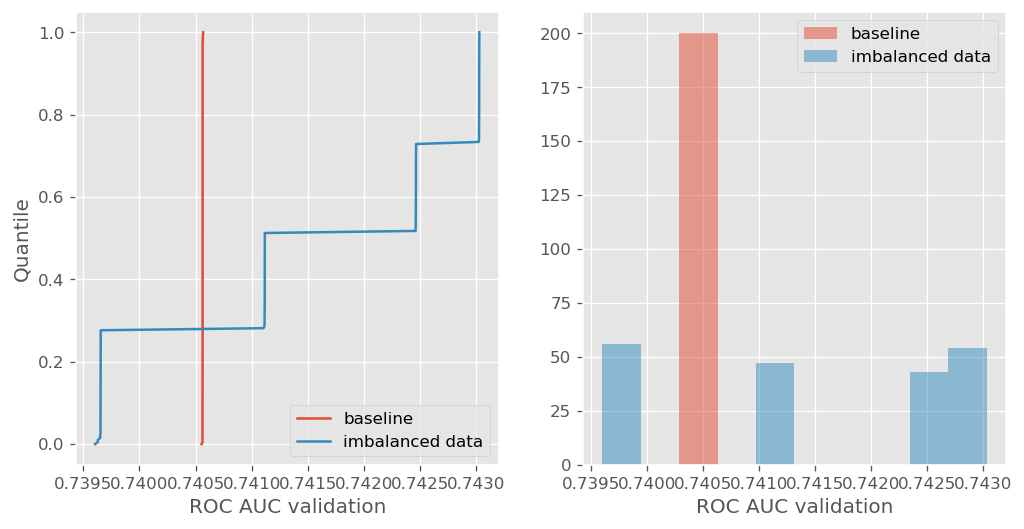

In [20]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_imbalanced = np.array([elem["value"] for elem in imbalanced_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_imbalanced])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_imbalanced), t, c="C1", label="imbalanced data")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_imbalanced, bins=bin_edges, alpha=0.5, label="imbalanced data")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [21]:
scores_imbalanced = get_top_test_scores(imbalanced_results, top_k=top_k, stages_options=stages_options_imbalanced, **sample_info)
print(np.mean(
    scores_imbalanced.reshape(-1, 1) > scores_baseline
))

print(f"mean diff {np.mean(scores_imbalanced) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

1.0
mean diff 0.002640


# Classifier choice

## Run models

In [23]:
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# change solver to allow for l1 penalty
setattr(logreg, "solver", "liblinear")

rf_classifier = RandomForestClassifier(random_state=seed)
setattr(rf_classifier, "pipeline_nm", "classifier_RF")

lgb_classifier = LGBMClassifier(random_state=seed)
setattr(lgb_classifier, "pipeline_nm", "classifier_LGB")

stages_options_classifier = {
    "cat_feat" : [woe_encoder],
    "scaling" : [StandSc_module],
    "feat_sel" : [sel_shuffl],
    "imb_data" : ["skip"],
    "classifier" : [logreg, lgb_classifier, rf_classifier]
}

hparams_options_classifier = {
    "classifier_LogReg" : lambda trial: {
        "classifier_LogReg__penalty" : trial.suggest_categorical("classifier_LogReg__penalty", ["l1", "l2"]),
        "classifier_LogReg__C" : trial.suggest_int("classifier_LogReg__C", low=1, high=100, step=1),
    },
    "classifier_RF" : lambda trial: {
        "classifier_RF__max_depth" : trial.suggest_categorical("classifier_RF__max_depth", [2, 4, 8, 16]),
        "classifier_RF__n_estimators" : trial.suggest_int("classifier_RF__n_estimators", low=100, high=1000, step=100),
    },
    "classifier_LGB" : lambda trial: {
        "classifier_LGB__boosting_type" : trial.suggest_categorical("classifier_LGB__boosting_type", ["gbdt", "goss"]),
        "classifier_LGB__max_depth" : trial.suggest_categorical("classifier_LGB__max_depth", [2, 4, 8, 16]),
        "classifier_LGB__n_estimators" : trial.suggest_int("classifier_LGB__n_estimators", low=50, high=300, step=50),
        "classifier_LGB__num_leaves" : trial.suggest_int("classifier_LGB__num_leaves", low=2, high=32, step=5),
    },
}

In [24]:
if load:
    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "r") as f:
        classifier_results = json.load(f)
else:
    # -- run grid search --
    kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=seed)
    study_classifier = optuna.create_study(
        direction='maximize',
        sampler=optuna.samplers.RandomSampler(seed=seed)
        )

    strategy="kfold"
    study_classifier.optimize(
        func=lambda trial: optimized_function(trial, stages_options=stages_options_classifier, hparams_options=hparams_options_classifier, loss=roc_auc_score, X=X_train, y=y_train, kf=kf),
        n_trials=n_total,
        # timeout=100,
        )

    # -- save results to json --
    classifier_results = [
        {"value" : study_classifier.trials[i].value, "params" : study_classifier.trials[i].params} for i in range(len(study_classifier.trials))
    ]

    with open(f"./{experiment_dir}/{dataset_nm}_classifier.json", "w") as f:
        json.dump(classifier_results, f)

[I 2022-04-28 18:50:38,244] A new study created in memory with name: no-name-21d905fe-3797-4996-ac05-4ebd7f819be9
[I 2022-04-28 18:50:39,417] Trial 0 finished with value: 0.7396273720351874 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 0, 'classifier_LogReg__penalty': 'l2', 'classifier_LogReg__C': 2}. Best is trial 0 with value: 0.7396273720351874.
[I 2022-04-28 18:50:43,342] Trial 1 finished with value: 0.7459433983388919 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 1, 'classifier_LGB__boosting_type': 'goss', 'classifier_LGB__max_depth': 8, 'classifier_LGB__n_estimators': 150, 'classifier_LGB__num_leaves': 22}. Best is trial 1 with value: 0.7459433983388919.
[I 2022-04-28 18:50:45,827] Trial 2 finished with value: 0.7527886118965894 and parameters: {'cat_feat': 0, 'scaling': 0, 'feat_sel': 0, 'imb_data': 0, 'classifier': 1, 'classifier_LGB__boosting_type': 'gbdt', 'classifier_LGB__max_depth': 4, '

## Results

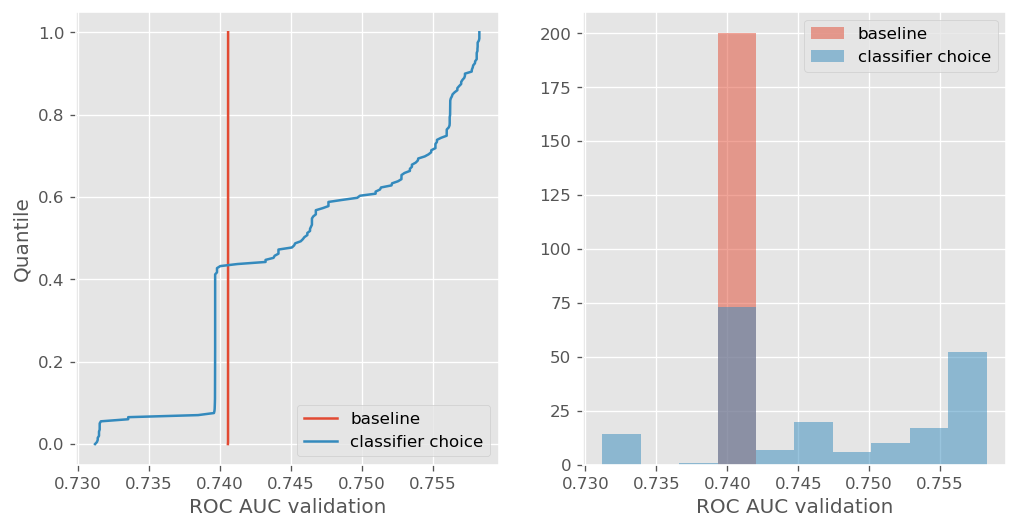

In [25]:
fig, ax = plt.subplots(1, 2, dpi=120, figsize=[10, 5])

auc_values_classifier = np.array([elem["value"] for elem in classifier_results])
t = np.linspace(0, 1, n_total)
_, bin_edges = np.histogram(np.r_[auc_values_baseline, auc_values_classifier])


ax[0].plot(np.sort(auc_values_baseline), t, c="C0", label="baseline")
ax[0].plot(np.sort(auc_values_classifier), t, c="C1", label="classifier choice")
ax[0].legend()

ax[0].set(xlabel="ROC AUC validation", ylabel="Quantile")

ax[1].hist(auc_values_baseline, bins=bin_edges, alpha=0.5, label="baseline")
ax[1].hist(auc_values_classifier, bins=bin_edges, alpha=0.5, label="classifier choice")
ax[1].legend()

ax[1].set(xlabel="ROC AUC validation");

In [26]:
# models_baseline = get_top_k_models(baseline_results, top_k=top_k, stages_options=stages_options_baseline)
scores_classifier = get_top_test_scores(classifier_results, top_k=top_k, stages_options=stages_options_classifier, **sample_info)
print(scores_classifier)
print(np.mean(
    scores_classifier.reshape(-1, 1) > scores_baseline
))
print(f"mean diff {np.mean(scores_classifier) - np.mean(scores_baseline):4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

[0.74830799 0.74830799 0.74830799 0.74830799 0.74839201 0.74831444
 0.74831444 0.74831444 0.748268   0.748268   0.748283   0.748283
 0.748283   0.748283   0.74881912 0.74876098 0.74745604 0.74901457
 0.74881041 0.74981225]
1.0
mean diff 0.022510
